In [606]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import metrics

from keras.utils import np_utils

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


In [607]:
#load data
train = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-training-true.data', header=None)

test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-testing.data')

In [608]:
#create column headers
train.columns = ['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'Label']
test.columns = ['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'Label']

In [609]:
train.head()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,Label
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9


In [610]:
train.describe()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,Label
count,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000
mean,2.508756,6.995242,2.497721,7.014194,2.510236,7.014154,2.495922,6.942463,2.497321,6.962735,0.621152
std,1.116483,3.749805,1.121767,3.766974,1.123148,3.744974,1.116009,3.747147,1.118732,3.741579,0.788361
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,4.000000,1.000000,4.000000,2.000000,4.000000,1.000000,4.000000,1.000000,4.000000,0.000000
50%,3.000000,7.000000,2.000000,7.000000,3.000000,7.000000,2.000000,7.000000,3.000000,7.000000,1.000000
75%,4.000000,10.000000,4.000000,10.000000,4.000000,10.000000,3.000000,10.000000,3.000000,10.000000,1.000000
max,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000,9.000000


<AxesSubplot:>

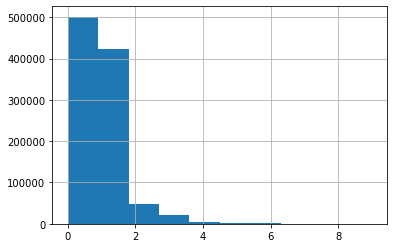

In [611]:
test['Label'].hist()

In [612]:
#get class counts
class_count = np.bincount(train['Label'])
train_rows, train_cols = np.shape(train)
data_distribution_percentage = (train['Label'].value_counts()) / len(train) * 100
data_distribution_percentage

0    49.952019
1    42.379048
2     4.822071
3     2.051180
4     0.371851
5     0.215914
6     0.143942
7     0.023990
9     0.019992
8     0.019992
Name: Label, dtype: float64

In [815]:
#split data for test and validation
disproportionate_sampling = train.groupby('Label', group_keys=False).apply(lambda x: x.sample(2)) #disproportionate stratified sampling
proportionate_sampling = train.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=1.0)) #proportionate sampling
proportionate_sampling

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,Label
11562,3,7,4,2,4,3,4,13,1,11,0
835,3,13,1,12,2,5,4,2,2,3,0
3969,3,9,4,8,4,4,1,2,3,5,0
16238,1,9,2,6,3,12,1,11,3,5,0
10881,4,7,4,9,4,13,4,4,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...
4,4,1,4,13,4,12,4,11,4,10,9
1,2,11,2,13,2,10,2,12,2,1,9
0,1,10,1,11,1,13,1,12,1,1,9
2,3,12,3,11,3,13,3,10,3,1,9


In [816]:
#remove validatation data set from main data set
final_train = train.merge(proportionate_sampling, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1) #merge
final_train

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,Label


In [817]:
train_full = train.copy()
train_full_classification = np.array(train_full.pop('Label'))
train_full = np.array(train_full)
train_full_classification = np_utils.to_categorical(train_full_classification, num_classes=10)
train_full_classification

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [818]:
#clean train data
train_data = final_train.copy()
train_classification = train_data.pop('Label')
train_data = np.array(train_data)
train_classification = np.array(train_classification)
train_classification = np_utils.to_categorical(train_classification, num_classes=10)

#normalize data
#train_data= tf.keras.utils.normalize(train_data, axis=1)
train_data

array([], shape=(0, 10), dtype=int64)

In [819]:
#clean validation data
val_data = proportionate_sampling.copy()
val_classification = np.array(val_data.pop('Label'))
val_data = np.array(val_data)
val_classification = np_utils.to_categorical(val_classification, num_classes=10)
val_classification

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [820]:
#clean test data
test_data = test.copy()
test_classification = np.array(test_data.pop('Label'))
test_data = np.array(test_data)
test_classification = np_utils.to_categorical(test_classification, num_classes=10)

In [821]:
#model metrics - precision and recall effective for highly imbalance data
METRICS = [
    'accuracy'
]

In [851]:
#callback for early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience= 15,
    mode='max',
    restore_best_weights=True)

In [852]:
#init weight
weight_generator = tf.keras.initializers.RandomNormal(mean=0, stddev=1.)
weight1 = weight_generator(shape=(1, 100))
weight2 = weight_generator(shape=(1, 100))
weight3 = weight_generator(shape=(1, 100))
weight4 = weight_generator(shape=(1, 10))

weight4

ERROR! Session/line number was not unique in database. History logging moved to new session 442


<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 0.03865508, -0.88486475,  1.0972427 , -0.4152805 , -0.91196084,
        -0.39895985,  0.14275688, -1.6266729 , -1.0656615 ,  0.17116508]],
      dtype=float32)>

In [853]:
#init bias
#data_distribution_percentage
bias = []
for i in data_distribution_percentage:
    bias.append(100 - i)
bias = np.array(bias)
bias

array([50.04798081, 57.62095162, 95.17792883, 97.94882047, 99.62814874,
       99.78408637, 99.85605758, 99.9760096 , 99.980008  , 99.980008  ])

In [854]:
#build model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(100, activation='relu')) #nodes, activition
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax')) #output

In [858]:
#parameters for training
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.001), loss= 'categorical_crossentropy',  metrics= METRICS) #optimizer, loss(error correction), 

In [859]:
#model.layers[3].get_weights()
#model.layers[4].set_weights([model.layers[4].get_weights(), bias])

In [860]:
#train model
train_model = model.fit(train_full, train_full_classification, epochs=1000, batch_size= 200, callbacks = [early_stopping], validation_data=(val_data, val_classification)) #add batch_size, validation_split=(1.0 - 0.0)

Train on 25010 samples, validate on 25010 samples
Epoch 1/1000
25010/25010 [==============================] - 1s 25us/sample - loss: 1.0808 - accuracy: 0.4896 - val_loss: 0.9887 - val_accuracy: 0.5121
Epoch 2/1000
25010/25010 [==============================] - 0s 13us/sample - loss: 0.9712 - accuracy: 0.5303 - val_loss: 0.9584 - val_accuracy: 0.5441
Epoch 3/1000
25010/25010 [==============================] - 0s 13us/sample - loss: 0.9559 - accuracy: 0.5463 - val_loss: 0.9479 - val_accuracy: 0.5509
Epoch 4/1000
25010/25010 [==============================] - 0s 10us/sample - loss: 0.9478 - accuracy: 0.5537 - val_loss: 0.9386 - val_accuracy: 0.5558
Epoch 5/1000
25010/25010 [==============================] - 0s 10us/sample - loss: 0.9421 - accuracy: 0.5536 - val_loss: 0.9419 - val_accuracy: 0.5635
Epoch 6/1000
25010/25010 [==============================] - 0s 10us/sample - loss: 0.9393 - accuracy: 0.5582 - val_loss: 0.9271 - val_accuracy: 0.5642
Epoch 7/1000
25010/25010 [==================

25010/25010 [==============================] - 0s 10us/sample - loss: 0.2077 - accuracy: 0.9287 - val_loss: 0.1906 - val_accuracy: 0.9413
Epoch 55/1000
25010/25010 [==============================] - 0s 10us/sample - loss: 0.1880 - accuracy: 0.9369 - val_loss: 0.1649 - val_accuracy: 0.9506
Epoch 56/1000
25010/25010 [==============================] - 0s 10us/sample - loss: 0.1916 - accuracy: 0.9341 - val_loss: 0.2102 - val_accuracy: 0.9192
Epoch 57/1000
25010/25010 [==============================] - 0s 11us/sample - loss: 0.1715 - accuracy: 0.9433 - val_loss: 0.1338 - val_accuracy: 0.9603
Epoch 58/1000
25010/25010 [==============================] - 0s 10us/sample - loss: 0.1296 - accuracy: 0.9633 - val_loss: 0.1159 - val_accuracy: 0.9671
Epoch 59/1000
25010/25010 [==============================] - 0s 10us/sample - loss: 0.1238 - accuracy: 0.9653 - val_loss: 0.1084 - val_accuracy: 0.9715
Epoch 60/1000
25010/25010 [==============================] - 0s 10us/sample - loss: 0.1176 - accuracy:

In [861]:
#model.get_weights()

In [862]:
#test model
#model.summary()
train_accuracy = model.evaluate(train_full, train_full_classification)

ERROR! Session/line number was not unique in database. History logging moved to new session 444
25010/25010 [==============================] - 0s 13us/sample - loss: 0.0200 - accuracy: 0.9965


In [863]:
test_accuracy = model.evaluate(val_data, val_classification)

25010/25010 [==============================] - 0s 13us/sample - loss: 0.0200 - accuracy: 0.9965


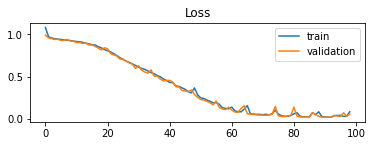

In [864]:
plt.subplot(211)
plt.title('Loss')
plt.plot(train_model.history['loss'], label='train')
plt.plot(train_model.history['val_loss'], label='validation')
plt.legend()

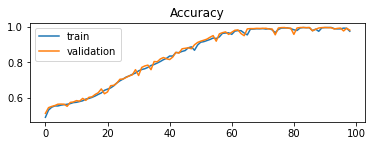

In [865]:
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(train_model.history['accuracy'], label='train')
plt.plot(train_model.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [866]:
#predict prob for test set
predict_probs = model.predict(test_data, verbose=0)
#predict_probs = predict_probs[:, 0]
#predict crisp classes for test set
#predict_classes = model.predict_classes(test_data, verbose=0)


In [867]:
#transform data to interpret actual class
test_actual_class = np.argmax(test_classification, axis=1)
test_actual_class

array([1, 1, 1, ..., 1, 1, 2], dtype=int64)

In [868]:
#transform prediction prob to interpret to actual class
predict_actual_probs = np.argmax(predict_probs, axis=1)
predict_actual_probs

array([1, 1, 1, ..., 1, 1, 2], dtype=int64)

In [869]:
#test_vector = np_utils.to_categorical(test_classification, num_classes=10)
print(sklearn.metrics.classification_report(test_actual_class, predict_actual_probs))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    501208
           1       0.99      1.00      1.00    422498
           2       0.97      0.95      0.96     47622
           3       0.96      0.95      0.95     21121
           4       0.67      0.45      0.54      3885
           5       0.03      0.00      0.00      1996
           6       0.90      0.74      0.81      1424
           7       0.63      0.21      0.32       230
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00         3

    accuracy                           0.99    999999
   macro avg       0.61      0.53      0.56    999999
weighted avg       0.99      0.99      0.99    999999



<AxesSubplot:>

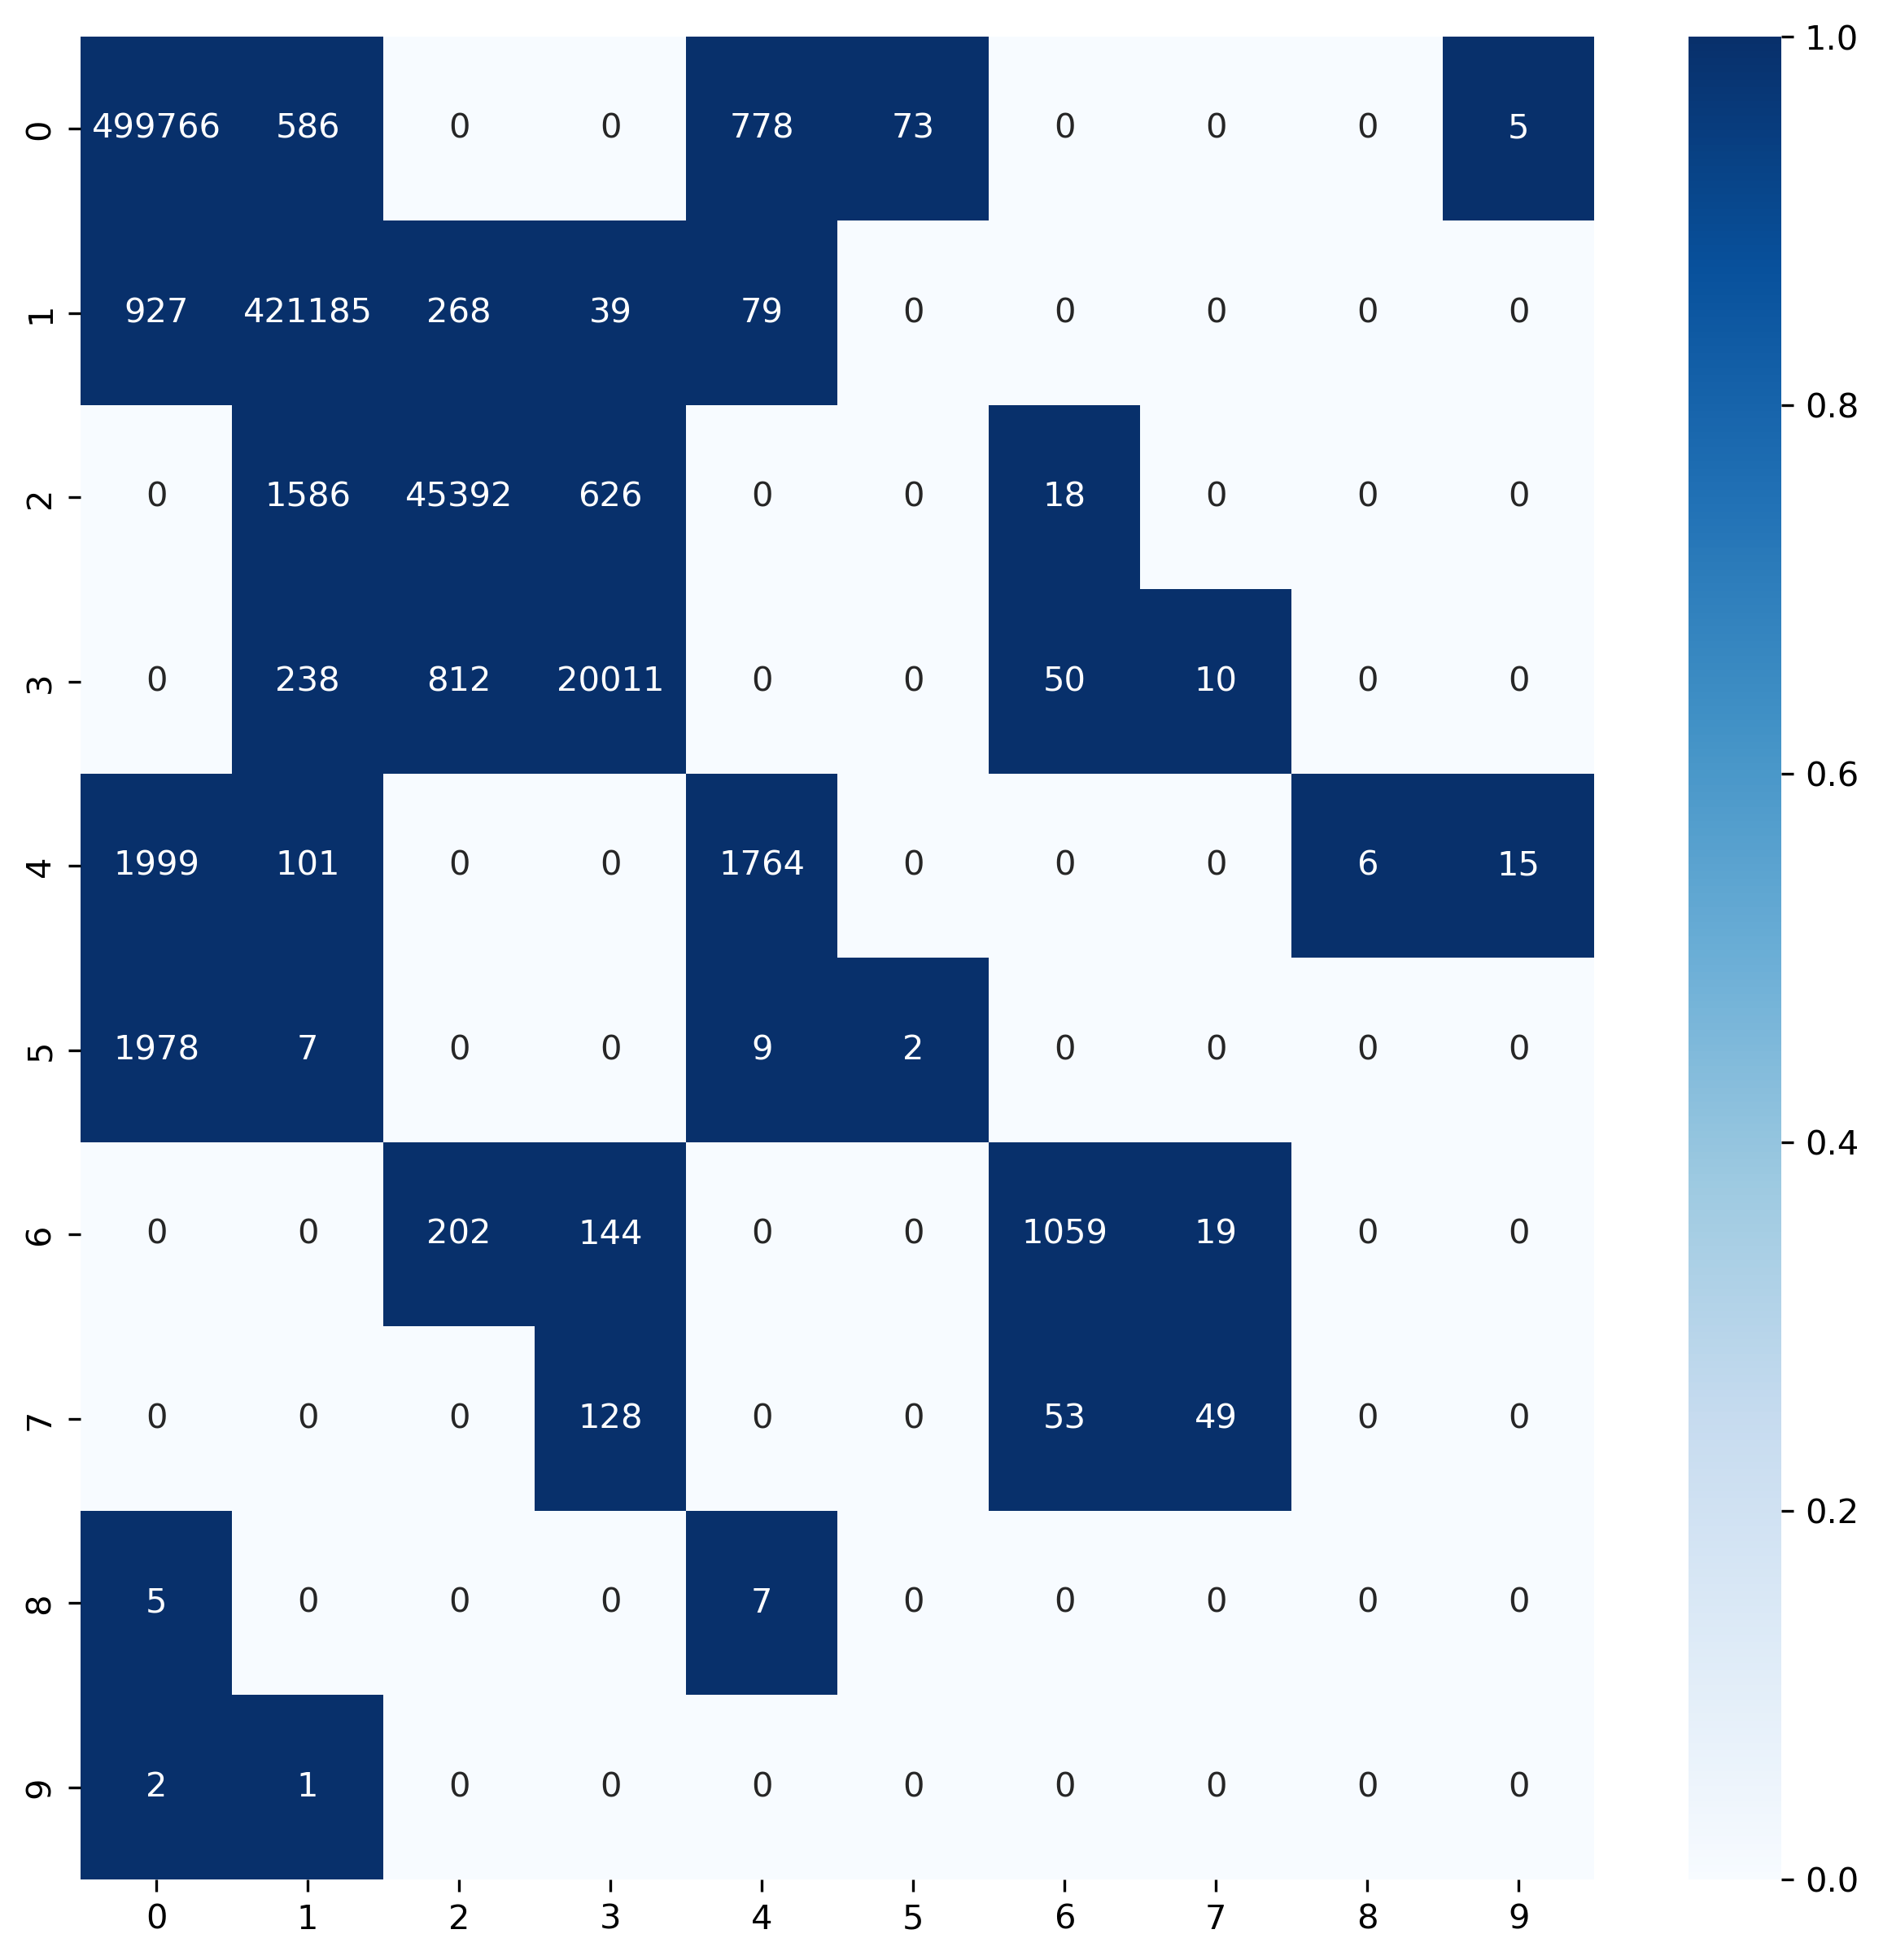

In [870]:
#confusion matrix
model_confusion_matrix = sklearn.metrics.confusion_matrix(test_actual_class, predict_actual_probs)

plt_confusion_matrix = pd.DataFrame(model_confusion_matrix)
plt.figure(figsize=(10, 10), dpi=300)

sns.heatmap(plt_confusion_matrix, cmap='Blues', vmin=0, vmax=1, annot= True, fmt='.0f')

In [847]:
shape_dict = {}
for layer in model.layers:
    if layer.get_weights() != []:
        shape_dict[layer.name] = np.shape(layer.get_weights()[0])
        np.savetxt(layer.name+".csv", layer.get_weights()[0].flatten(), delimiter=',')

np.savetxt(bias+".csv", model.layer[4].get_weights()[1], delimiter=',')

In [843]:
#hyper parameter
#input size = size of data set
#nodes = 100
#layers = 5
#classes = 10
#epochs 37
# batch 
# learning rate = 0.001

In [840]:
#feed forward function

In [841]:
#loss function mean-squared

In [812]:
#back propagation

In [813]:
#training loop

In [814]:
#proposed solution
'''
multilayer perceptron based on different research
3 layer
10 nodes

source:
https://ieeexplore.ieee.org/document/7813761
https://towardsdatascience.com/a-good-machine-learning-classifiers-accuracy-metric-for-the-poker-hand-dataset-44cc3456b66d
https://walintonc.github.io/papers/ml_pokerhand.pdf - add other ml techniques
imbalance data: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
'''

'\nmultilayer perceptron based on different research\n3 layer\n10 nodes\n\nsource:\nhttps://ieeexplore.ieee.org/document/7813761\nhttps://towardsdatascience.com/a-good-machine-learning-classifiers-accuracy-metric-for-the-poker-hand-dataset-44cc3456b66d\nhttps://walintonc.github.io/papers/ml_pokerhand.pdf - add other ml techniques\nimbalance data: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data\n'

In [69]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]